# TI3145TU Midterm Assignment 
## Football Players Wages

We hope you enjoy this assignment, good luck!

Student names: XXX

Student numbers: XXX

### Imports

In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor

import matplotlib.pyplot as plt

import random

### Load data

In [2]:
# These are your training samples along with their labels
data = pd.read_csv('football_wages.csv')
data.head()

# You need to extract the features and the regression target. The regression target is 'log_wages'. 

,age,height_cm,weight_kg,nationality_name,overall,potential,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,...,movement_reactions,movement_balance,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,log_wages
0,27.0,183.0,76.0,b'Korea Republic',57.0,58.0,54.0,30.0,55.0,53.0,...,60.0,67.0,63.0,58.0,9.0,13.0,8.0,11.0,10.0,3.000000
1,21.0,182.0,70.0,b'France',61.0,72.0,58.0,63.0,46.0,62.0,...,47.0,65.0,31.0,33.0,9.0,11.0,9.0,12.0,11.0,3.000000
2,35.0,182.0,75.0,b'Korea Republic',68.0,68.0,62.0,68.0,68.0,70.0,...,61.0,69.0,36.0,40.0,8.0,12.0,7.0,12.0,6.0,3.301030
3,29.0,169.0,70.0,b'Paraguay',67.0,67.0,62.0,55.0,50.0,71.0,...,59.0,84.0,40.0,55.0,6.0,10.0,11.0,15.0,9.0,2.698970
4,30.0,176.0,74.0,b'Austria',65.0,65.0,63.0,49.0,53.0,63.0,...,58.0,75.0,65.0,64.0,12.0,15.0,10.0,8.0,10.0,3.477121


In [3]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

def KNReg():
    return KNeighborsRegressor()
def SGDReg():
    return SGDRegressor( random_state=random_state_seed )
def MAE( pred, true ):
    return np.mean( np.abs( pred - true ) )

random_state_seed = 42

X = data.drop(columns=['log_wages'])
y = data['log_wages']

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=random_state_seed )

baseline_MAE_train = MAE( y_train, y_train.mean() )
baseline_MAE_test = MAE( y_test, y_test.mean() )

print( f"If our regressor simply assigned the mean of our data to samples our MAE would be:" )
print( f"Train: {baseline_MAE_train}" )

If our regressor simply assigned the mean of our data to samples our MAE would be:
Train: 0.4912703291303276


### Dataset Visualization

In [4]:
from bokeh.plotting import figure, gridplot, show
from bokeh.layouts import column
from bokeh.transform import factor_cmap, linear_cmap
from bokeh.models import ColumnDataSource, HoverTool, NumeralTickFormatter, BasicTicker, PrintfTickFormatter, axes
from bokeh.models.annotations import Label
from bokeh.io import output_notebook
output_notebook()

def create_color_map():
    from bokeh.colors import RGB

    neg_color = RGB( 0, 0, 255 )
    pos_color = RGB( 255, 0, 0 )

    colors_low = []
    colors_high = []
    for i in range(1,129):
        colors_high.append( RGB( max( pos_color.r, 255 - 2*i ), max( pos_color.g, 255 - 2*i ), max( pos_color.b, 255 - 2*i ) ) )
        colors_low.append( RGB( max( neg_color.r, 255 - 2*i ), max( neg_color.g, 255 - 2*i ), max( neg_color.b, 255 - 2*i ) ) )

    return list(reversed(colors_low)) + colors_high

feature_corr = X.corr(numeric_only=True)
cols = {
        "x_cols": list( feature_corr.columns ),
        "y_cols": list( reversed(feature_corr.columns) )
    }
matrix = pd.DataFrame( feature_corr.stack(), columns=["corr"] ).reset_index()
data = {
    "x": matrix['level_0'].values,
    "y": matrix['level_1'].values,
    "corr": matrix['corr'].values
}
source = ColumnDataSource(data)
fig = figure( title=f"Pearson Correlation",
              x_range=cols['x_cols'], y_range=cols['y_cols'],
              width=700, height=700,
              tools="hover", toolbar_location='above',
              tooltips=[('Column:', "@x"),('Row:', "@y"),('Value:', "@corr")],
              x_axis_location='above'
            )
fig.grid.grid_line_color = None
fig.axis.axis_line_color = None
fig.axis.major_tick_line_color = None
fig.axis.major_label_standoff = 0
fig.xaxis.major_label_orientation = 0.8
fig.yaxis.major_label_orientation = 0.8
colors = create_color_map()
mapper = linear_cmap( "corr", colors, low=-1, high=1)
heatmap = fig.rect( x="x", y="y", width=1, height=1, source=source, fill_color=mapper, line_color=None )
fig.add_layout( heatmap.construct_color_bar(
                    ticker=BasicTicker(),
                    border_line_color=None,
                ), 'right'
              )

show(fig)

Loading BokehJS ...

### Pipeline 1

In [5]:
def get_basic_pipeline( data, model ):
    one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    # Define the sets of categorical and numerical columns
    categorical_columns = data.select_dtypes(include=["object", "category"])

    preprocess = ColumnTransformer([
        ("cat_pipeline", one_hot_encoder, categorical_columns.columns)
    ])

    return Pipeline([("preprocess", preprocess), ("model", model)])

### Pipeline 2

In [6]:
def get_preprocessed_pipeline( data, model ):
    oh_encoder = OneHotEncoder( handle_unknown="ignore", sparse_output=False )
    scaler = StandardScaler()
    pca = PCA( svd_solver="full", n_components=0.99, random_state=random_state_seed )
    
    def bmi( df ):
        df["bmi"] = df["weight_kg"]/((df["height_cm"]/100)**2 )
        df.drop(columns=["weight_kg","height_cm"])
        return df
    bmi_transformer = FunctionTransformer( bmi )
    
    categorical_columns = data.select_dtypes(include=["object", "category"])
    numerical_columns = data.select_dtypes(exclude=["object", "category"])
    
    preprocessor = ColumnTransformer( transformers = [
            ( "categorical", oh_encoder, categorical_columns.columns ),
            ( "numerical", scaler, numerical_columns.columns ),
            ( "bmi", bmi_transformer, ["height_cm","weight_kg"] ),
        ],
        remainder="passthrough" )
    pipeline = Pipeline(steps=[( "preprocessing", preprocessor ), ( "pca", pca ), ( "training", model )])
    return pipeline

In [9]:
def train_model_pipeline( pipeline_fun, model, X, X_train, y_train ):
    pipeline = pipeline_fun( X, model )
    pipeline.fit( X_train, y_train )
    y_pred = pipeline.predict( X_train )
    return pipeline, MAE( y_pred, y_train )

def evaluate_pipeline( pipeline, X, y ):
    y_pred = pipeline.predict( X )
    return MAE( y_pred, y )

SGD_pipeline_basic, SGD_MAE_train_basic = train_model_pipeline( pipeline_fun=get_basic_pipeline, model=SGDReg(), X=X, X_train=X_train, y_train=y_train )
SGD_MAE_test_basic = evaluate_pipeline( SGD_pipeline_basic, X=X_test, y=y_test )
KN_pipeline_basic, KN_MAE_train_basic = train_model_pipeline( pipeline_fun=get_basic_pipeline, model=KNReg(), X=X, X_train=X_train, y_train=y_train )
KN_MAE_test_basic = evaluate_pipeline( KN_pipeline_basic, X=X_test, y=y_test )

print( f"Our basic pipeline SGD regressor has a MAE of:" )
print( f"Train: {SGD_MAE_train_basic:.6f}" )
print( f"Test: {SGD_MAE_test_basic:.6f}\n" )

print( f"Our Basic pipeline KNeighbors regressor has a MAE of:" )
print( f"Train: {KN_MAE_train_basic:.6f}" )
print( f"Test: {KN_MAE_test_basic:.6f}\n" )

SGD_pipeline, SGD_MAE_train = train_model_pipeline( pipeline_fun=get_preprocessed_pipeline, model=SGDReg(), X=X, X_train=X_train, y_train=y_train )
SGD_MAE_test = evaluate_pipeline( SGD_pipeline, X=X_test, y=y_test )
KN_pipeline, KN_MAE_train = train_model_pipeline( pipeline_fun=get_preprocessed_pipeline, model=KNReg(), X=X, X_train=X_train, y_train=y_train )
KN_MAE_test = evaluate_pipeline( KN_pipeline, X=X_test, y=y_test )

print( f"Our SGD regressor has a MAE of:" )
print( f"Train: {SGD_MAE_train:.6f}" )
print( f"Test: {SGD_MAE_test:.6f}\n" )

print( f"Our KNeighbors regressor has a MAE of:" )
print( f"Train: {KN_MAE_train:.6f}" )
print( f"Test: {KN_MAE_test:.6f}\n" )

Our basic pipeline SGD regressor has a MAE of:
Train: 0.452392
Test: 0.448823

Our Basic pipeline KNeighbors regressor has a MAE of:
Train: 0.441379
Test: 0.455424

Our SGD regressor has a MAE of:
Train: 0.281356
Test: 0.290938

Our KNeighbors regressor has a MAE of:
Train: 0.250824
Test: 0.320997



### GridSearch

In [10]:
from sklearn.model_selection import GridSearchCV

In [15]:
def SGD_Gridsearch(X, X_train, y_train):
    import warnings
    warnings.filterwarnings('ignore')

    params = {
        "loss": [ 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive' ], # 4
        "penalty": [ 'elasticnet' ], # 1
        "alpha": [ 10**(i-5) for i in range(3) ], # 3
        "l1_ratio": [ 0.1*i for i in range(11) ], # 10
        "epsilon": [ 10**(i-3) for i in range(3) ], # 3
        "learning_rate": [ 'optimal', 'invscaling', 'adaptive' ], # 3
        "eta0": [ 10**(i-3) for i in range(3) ], # 4
        "shuffle": [ True ],
        "random_state": [ random_state_seed ],
        "warm_start": [ False ]
    }
    model = GridSearchCV( SGDRegressor(), params, cv = 5, scoring='neg_mean_absolute_error' )
    _, mean_absolute_error = train_model_pipeline( get_preprocessed_pipeline, model, X=X, X_train=X_train, y_train=y_train )
    return mean_absolute_error, model

mean_absolute_error_sgd, model = SGD_Gridsearch( X, model )


print( "MAE: ", mean_absolute_error_sgd )
print( "Optimal params: ", model.best_params_ )
    

MAE:  0.27279203091715687
Optimal params:  {'alpha': 0.001, 'epsilon': 0.01, 'eta0': 0.1, 'l1_ratio': 0.1, 'learning_rate': 'adaptive', 'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'random_state': 42, 'shuffle': True, 'warm_start': False}


In [17]:
GS_SGD_pipeline, GS_SGD_MAE_train = train_model_pipeline( get_preprocessed_pipeline, model.best_estimator_, X=X, X_train=X_train, y_train=y_train )
GS_SGD_MAE_test = evaluate_pipeline( GS_SGD_pipeline, X=X_test, y=y_test )

print( f"Our SGD regressor has a MAE of:" )
print( f"Train: {GS_SGD_MAE_train:.6f}" )
print( f"Test: {GS_SGD_MAE_test:.6f}\n" )

Our SGD regressor has a MAE of:
Train: 0.272792
Test: 0.281310



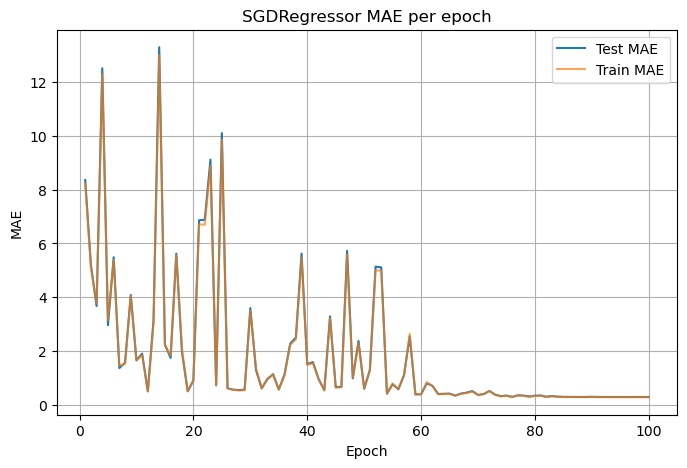

0.27284690672002876


In [18]:
# Define pipeline steps 
full_pipeline = get_preprocessed_pipeline( X, "None" )
preproc = full_pipeline.named_steps['preprocessing']
pca = full_pipeline.named_steps['pca']

# Fit preprocessors on training data
visual_train_X = preproc.fit_transform(X_train)

# Fit PCA on preprocessed training data
visual_train_X = pca.fit_transform(visual_train_X)

# Fit preprocessors on training data
visual_test_X = preproc.transform(X_test)

# Fit PCA on preprocessed training data
visual_test_X = pca.transform(visual_test_X)

epochs = 100
test_mae_per_epoch = []
train_mae_per_epoch = []

for epoch in range(1, epochs + 1):
    # Deterministically fit new regressor with best parameters from gridserach, for 'epoch' iterations
    best_SGD_model = SGDRegressor(**model.best_params_, max_iter=epoch)
    best_SGD_model.fit( visual_train_X, y_train )

    # Track train MAE
    y_pred_train = best_SGD_model.predict(visual_train_X)
    train_MAE = MAE( y_pred_train, y_train )
    train_mae_per_epoch.append(train_MAE)
    # Track test MAE
    y_pred_test = best_SGD_model.predict(visual_test_X)
    test_mae = MAE(y_pred_test, y_test)
    test_mae_per_epoch.append(test_mae)


# Plot MAE vs epoch
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), test_mae_per_epoch, label='Test MAE')
plt.plot(range(1, epochs+1), train_mae_per_epoch, label='Train MAE', alpha=0.7)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('SGDRegressor MAE per epoch')
plt.legend()
plt.grid(True)
plt.show()

print(min(train_mae_per_epoch))

In [20]:
def KN_Gridsearch(X_train, y_train):
    import warnings
    warnings.filterwarnings('ignore')
    
    # n_neighbors: number of neighbors to consider
    # p: power parameter for the Minkowski metric

    params = {
        "n_neighbors": [i for i in range(1, 30)], # 30
        "weights": [ 'uniform', 'distance' ], # 2
        "leaf_size": [10, 20, 30, 40, 50], # 5
        "p": [1,2,3,5,10] # 5
    }
    model = GridSearchCV( KNeighborsRegressor(), params, cv = 5, scoring='neg_mean_absolute_error', n_jobs=-1 )

    _, mean_absolute_error = train_model_pipeline( get_preprocessed_pipeline, model, X=X, X_train=X_train, y_train=y_train )
    return mean_absolute_error, model

mean_absolute_error_kn, model = KN_Gridsearch(X_train, y_train)
print("MAE: ", mean_absolute_error_kn)
print("Optimal params: ", model.best_params_) 
print("Best score: ", model.best_score_)   

MAE:  1.0744383160954385e-13
Optimal params:  {'leaf_size': 10, 'n_neighbors': 14, 'p': 1, 'weights': 'distance'}
Best score:  -0.302582580868601


In [21]:
GS_SGD_pipeline, GS_SGD_MAE_train = train_model_pipeline( get_preprocessed_pipeline, model.best_estimator_, X=X, X_train=X_train, y_train=y_train )
GS_SGD_MAE_test = evaluate_pipeline( GS_SGD_pipeline, X=X_test, y=y_test )

print( f"Our SGD regressor has a MAE of:" )
print( f"Train: {GS_SGD_MAE_train:.6f}" )
print( f"Test: {GS_SGD_MAE_test:.6f}\n" )

Our SGD regressor has a MAE of:
Train: 0.000000
Test: 0.312627



### Autograder 

In the autograder you will need to provide two things: 1) estimate of the MAE of your model on unseen data, 2) the predictions on the autograder data. For the autograder data we only provide the features and not the regression targets. Thus, you cannot compute the MAE on this data yourself - you need to estimate that with the data provided above. 

In [ ]:
data_autograder = pd.read_csv('football_autograde.csv')
data_autograder.head()


In [ ]:
# TODO Replace this with your own estimate of the MAE of your best model
estimate_MAE_on_new_data = np.array([mean_absolute_error_sgd])

# TODO Replace this with the predictions of your best model
# via e.g. prediction = model.predict(data_autograder)
# your predictions here should again be the $log_{10}(wage)$ of the football player, just as in the provided data. 
predictions_autograder_data = SGD_pipeline.predict( data_autograder )

# Upload this file to the Vocareum autograder:
result = np.append(estimate_MAE_on_new_data, predictions_autograder_data)
pd.DataFrame(result).to_csv("autograder_submission.txt", index=False, header=False)